In [5]:
import os
import glob
from PIL import Image
from io import BytesIO
import numpy as np
import boto3
import matplotlib.pyplot as plt


In [ ]:
#To upload data to S3 via cli - aws s3 cp data/JPEGImages s3://cair-data-sb/JPEGImages

In [ ]:
#To download an entire Amazon S3 bucket to a local directory on your instance. - aws s3 sync s3://cair-data-sb/JPEGImages/ .

## Data Analysis - 
Our dataset consists of images of different widths and heights. 
Let us first focus on images that are of particular size - say height =375 


In [9]:
#data analysis = 
# One sample image
a = Image.open('/data/JPEGImages/2007_000042.jpg')
print(type(a))
w,h = a.size 
print(w,h)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
500 335


In [10]:
# Another sample image
a = Image.open('/data/JPEGImages/2007_009346.jpg')
print(type(a))
w,h = a.size 
print(w,h)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
500 375


In [ ]:
#Uncomment N if you want to work on smaller or specific number of images
#N = 5000
voc_image_dir = "./data/JPEGImages/"
voc_image_files = glob.glob(os.path.join(voc_image_dir,'*.jpg'))#[:N]
train_voc_image_files = []

widths = []
for f_img in voc_image_files:
    img = Image.open(f_img)
    if img.size[-1] == 375: #(height = 375)
        train_voc_image_files.append(f_img)

## Data Preparation

#### For consistency let us resize all the images to a particular size and then seam carve the images to a different size (width)

In [ ]:
# resize for consistency
resize_height = 384
resize_width = 496

## seam carved size
new_height = 384
new_width = 400

### Seam Carving

In [ ]:
from seam_carving import SeamCarver

In [ ]:
for input_image in voc_image_files:
    in_image = cv2.imread(input_image)
    in_image = cv2.resize(in_image, dsize=(resize_width, resize_height)).astype(np.float64)
    new_img = SeamCarver(in_image, new_height, new_width)
    new_img.save_result(filename= "seam_output/image/" + input_image.split('/')[-1])
    cv2.imwrite("seam_output/mask/mask_" + input_image.split('/')[-1], new_img.seam_mask*255)

### Seam Carving with object detection

Looking at the seams generated, sometimes the seams run over the objects and thereby distorting the objects. It would be better we could run object detection and make sure the seams do not run over the objects.
Using Amazon Rekognition let us detect objects.

In [ ]:
import boto3
client = boto3.client('rekognition')

def object_boundaries(photo):
    with open(photo, 'rb') as image:
        response = client.detect_labels(Image={'Bytes': image.read()})

    boundaries = np.array(Image.open(photo))
    w,h = boundaries.shape[:2]
    
    output = []
     
    for label in response['Labels']:
        for instance in label['Instances']:
            box = instance['BoundingBox']
            left = w * box['Left']
            top = h * box['Top']
            width = w * box['Width']
            height = h * box['Height']
            output.append(np.array([top, left, width, height]).astype('uint'))
    return output

In [ ]:
for photo in voc_image_files:
    output = object_boundaries(photo)

    ## write object mask
    print (mask.shape, image.shape[:2])
    image = cv2.imread(photo)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = np.array(image).astype('uint8')
    res = image
    for y,x,w,h in output[:1]:
        #image = cv2.rectangle(image, (x,y), (x+w, y+h), (255,0,0), 2) 
        mask = np.zeros(image.shape[:2], np.uint8)
        mask[y:y+h, x:x+w] = 255
        res = cv2.bitwise_and(res, res, mask=mask)
        
    fname = "object_masks/om_" + photo.split('/')[-1]
    cv2.imwrite(fname, cv2.cvtColor(res, cv2.COLOR_RGB2BGR))

In [ ]:
#Seam Removing and Insertion with Mask
#When generating energy map, the region protected by mask are weighted with a very high positive value. 
#This guarantees that the minimum seam will NOT be routed through the masked region so that we can provent pixels 
#at this region from removing or distorting because of seam insertion.

for i, input_image in enumerate(voc_image_files):
    try:
        in_image = cv2.imread(input_image)
        in_image = cv2.resize(in_image, dsize=(resize_width, resize_height)).astype(np.float64)
        mask_fname = "object_masks/om_" + input_image.split('/')[-1] 
        new_img = SeamCarver(in_image, new_height, new_width, protect_mask=mask_fname)
        new_img.save_result(filename= "seam_output_with_om/" + input_image.split('/')[-1])
        cv2.imwrite("seam_output_with_om/mask_" + input_image.split('/')[-1], new_img.seam_mask*255)
        print (i, input_image)
    except:
        pass

In [ ]:
# Analysis of the generated seams 

[[2.63911e+05 2.41650e+04 5.00240e+04 ... 3.83300e+04 2.00540e+04
  1.81000e+02]
 [2.62129e+05 1.06240e+05 6.26820e+04 ... 4.21240e+04 3.45380e+04
  2.56000e+02]
 [2.58556e+05 1.13536e+05 6.41510e+04 ... 4.81770e+04 3.80940e+04
  2.79000e+02]
 ...
 [2.60616e+05 1.29369e+05 7.17570e+04 ... 5.81340e+04 4.57920e+04
  3.42000e+02]
 [2.64667e+05 1.18585e+05 5.78910e+04 ... 6.42820e+04 5.11330e+04
  4.02000e+02]
 [2.67699e+05 2.52560e+04 5.31760e+04 ... 6.60400e+04 6.02120e+04
  4.92810e+04]]


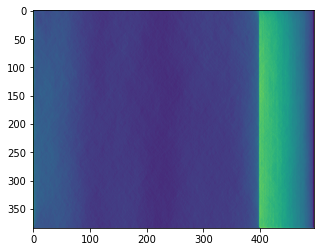

In [6]:
#After seam carving , collect the mask and check the seam distribution using heat maps

sm_dir = "seam_output_with_om/"
sm_files = glob.glob(os.path.join(sm_dir,'*.jpg'))

#heat map for seam carved mask
a = np.zeros([384, 496])
for f in sm_files:
    b = Image.open(f)
    b = np.array(b)
    #print(b.shape) #(384, 496)
    c = np.add(a, b)
    a = c
print(c)

plt.imshow(c)


In [ ]:
# The heat map is heavily imbalanced. ie. most of the seams are on the right side of the image
# Lets try to balance it like this -


In [7]:
def pixel_ratios(sm_files):
    # Calculates the ratio of number of seam pixel in the mask split
    for f in sm_files:
        a = Image.open(f)
        w, h = a.size
        a = np.array(a)
        b = 0
        split_sum_list = []
        for i in range(0,4):
            split = a[:, b:int(b+w/4)-1] 
            b = b+int(w/4)
            split_sum_list.append(np.sum(split))
        ratio = split_sum_list/ np.linalg.norm(split_sum_list)
        ratios.append(ratio)
    return ratios

In [8]:
ratios = []
ratios = pixel_ratios(sm_files)

In [9]:
print(ratios[100])

[0.93303582 0.35978028 0.00151982 0.        ]


In [12]:
split_1 = []
split_2 = []
split_3 = []
split_4 = []
few_seams = []

for i in range(0, len(ratios)):
    if ratios[i][0] > 0.5:
        split_1.append(i)
    elif ratios[i][1] > 0.5:
        split_2.append(i)
    elif ratios[i][2] > 0.5:
        split_3.append(i)
    elif ratios[i][3] > 0.5:
        split_4.append(i)
    else:
        few_seams.append(i)

In [15]:
len(split_1), len(split_2), len(split_3), len(split_4), len(few_seams)

(677, 226, 226, 807, 0)

Since the minimum number of images with seams in the middle part of the image is 226, we will have to consider only 226 images with seams in left and right side of the image

In [ ]:
#Create a folder for balanced masks
import shutil, os
balanced_mask_dir = "/balanced_mask"

for i in range(0, 226):
    f = sm_files[split_4[i]]
    shutil.copy(f, balanced_mask_dir)

[[1.00109e+05 9.87400e+03 1.82210e+04 ... 1.09770e+04 6.67100e+03
  6.00000e+01]
 [9.95170e+04 3.85640e+04 2.18450e+04 ... 1.25240e+04 9.97800e+03
  6.40000e+01]
 [9.77550e+04 4.10770e+04 2.38570e+04 ... 1.50210e+04 1.05200e+04
  8.00000e+01]
 ...
 [9.64320e+04 4.89960e+04 2.54030e+04 ... 1.55890e+04 1.30640e+04
  9.60000e+01]
 [9.74960e+04 4.38750e+04 1.98170e+04 ... 1.73690e+04 1.50980e+04
  1.27000e+02]
 [9.85780e+04 7.35800e+03 1.92610e+04 ... 1.83630e+04 1.58430e+04
  1.50590e+04]]


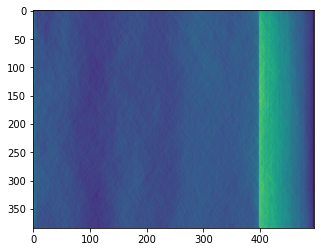

In [16]:

smb_dir = "/balanced_mask"
smb_files = glob.glob(os.path.join(smb_dir,'*.jpg'))

#heat map for seam carved mask
a = np.zeros([384, 496])
for f in smb_files:
    b = Image.open(f)
    b = np.array(b)
    #print(b.shape) #(384, 496)
    c = np.add(a, b)
    a = c
print(c)

plt.imshow(c)